Current sigma value: 1.0
Current sigma value: 2.0
Parameters of the largest circle:
Center: (110, 258)
Radius: 15
Sigma value: 2.0


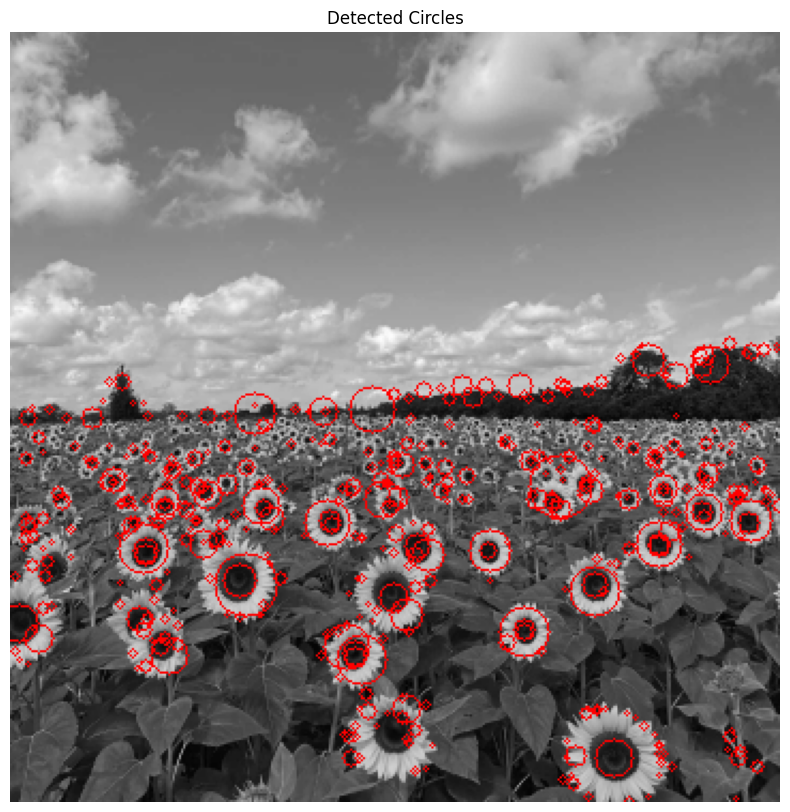

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the sunflower field image
image = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Set up parameters for scale-space extrema detection
min_sigma = 1.0  # Minimum sigma value (smaller values for smaller blobs)
max_sigma = 2.0  # Maximum sigma value (larger values for larger blobs)
num_sigma = 2 # Number of sigma values to test
threshold = 0.35  # Threshold for blob detection

# Create an empty list to store detected circles
circles = []

# Loop through different sigma values to detect blobs at different scales
for sigma in np.linspace(min_sigma, max_sigma, num_sigma):

    # Print the current sigma value to the console
    print(f"Current sigma value: {sigma}")

    # Apply LoG (Laplacian of Gaussian) to the grayscale image with the current sigma
    blurred = cv2.GaussianBlur(gray_image, (0, 0), sigma)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)

    # Calculate the absolute Laplacian values
    abs_laplacian = np.abs(laplacian)

    # Create a binary image where blobs are detected using the threshold
    blob_mask = abs_laplacian > threshold * abs_laplacian.max()

    # Find contours in the blob mask
    contours, _ = cv2.findContours(blob_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through the detected contours and fit circles to them
    for contour in contours:
        if len(contour) >= 5:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius, sigma))

# Sort the detected circles by radius in descending order
circles.sort(key=lambda x: -x[1])

# Report the parameters of the largest circle
largest_circle = circles[0]
center, radius, sigma = largest_circle

print("Parameters of the largest circle:")
print(f"Center: {center}")
print(f"Radius: {radius}")
print(f"Sigma value: {sigma}")

# Set the desired line thickness for drawn circles
line_thickness = 1

# Draw all detected circles with the specified line thickness
output_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
for circle in circles:
    center, radius, _ = circle
    cv2.circle(output_image, center, radius, (0, 0, 255), line_thickness)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected Circles')
plt.show()



Number of inliers in the line: 16
Parameters of the estimated line:
a: 0.7080986693010423
b: 0.7061134997534697
d: 1.5303717301982513
Number of remnant points: 84
Number of inliers in the circle: 16
Parameters of the estimated circle:
x_center: 2.0388812056906938
y_center: 2.905374551155992
radius: 9.971739443086292


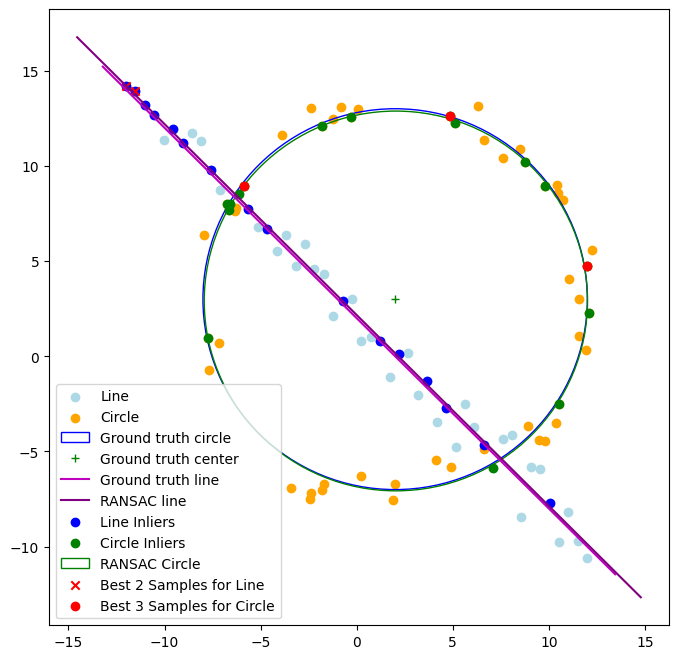

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(1)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)

X_circ = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
m, b = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)

X_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create X
X = np.vstack((X_circ, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], color = 'lightblue', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color = 'orange', label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = m * x_range + b
plt.plot(x_range, y_range, color='m', label='Ground truth line')



# Define a function to calculate the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 2, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        
        a, b, d = line_equation_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a*X[:,0] + b*X[:,1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters
iterations = 10000
threshold = 0.15
min_inliers = 15

# Estimate the line using RANSAC
best_line_model, Line_inlier_indices = ransac_line(X_line, iterations, threshold, min_inliers)

# print(best_line_model)
print("Number of inliers in the line:", len(Line_inlier_indices))
print("Parameters of the estimated line:")
print(f"a: {best_line_model[0]}")
print(f"b: {best_line_model[1]}")
print(f"d: {best_line_model[2]}")


# Define a function to calculate the circle equation from three points
def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    # Calculate the midpoints of two line segments
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    
    # Calculate the slopes of the two lines
    if y2 - y1 == 0:
        slope1 = 0  # Avoid division by zero
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0  # Avoid division by zero
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    # Calculate the center of the circle
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1
    
    # Calculate the radius
    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2)
    
    return x_center, y_center, radius

# RANSAC to fit a circle
def ransac_circle(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        x3, y3 = X[sample_indices[2]]
        
        x_center, y_center, radius = circle_equation_from_points(x1, y1, x2, y2, x3, y3)
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((X[:, 0] - x_center)**2 + (X[:, 1] - y_center)**2) - radius)
        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2  # Adjust the threshold as needed
circle_min_inliers = 15

# Identify the remnant points (not explained by the line)
remnant_indices = [i for i in range(len(X)) if i not in Line_inlier_indices]
remnant_points = X[remnant_indices]

# Print the number of remnant points
print("Number of remnant points:", len(remnant_points))

# Estimate the circle using RANSAC
best_circle_model, circle_inlier_indices = ransac_circle(remnant_points, circle_iterations, circle_threshold, circle_min_inliers)

# print(best_circle_model)
print("Number of inliers in the circle:", len(circle_inlier_indices))
print("Parameters of the estimated circle:")
print(f"x_center: {best_circle_model[0]}")
print(f"y_center: {best_circle_model[1]}")
print(f"radius: {best_circle_model[2]}")

# Plot the results

# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line', color='purple')


ax.scatter(X_line[Line_inlier_indices, 0], X_line[Line_inlier_indices, 1], color='blue', label='Line Inliers')


# Find the best 2 samples for the line
best_line_sample_indices = Line_inlier_indices[:2]
best_line_samples = X_line[best_line_sample_indices]


# Plot the inliers of the circle
ax.scatter(remnant_points[circle_inlier_indices, 0], remnant_points[circle_inlier_indices, 1], color='g', label='Circle Inliers')

# Plot the estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices)
best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]


# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')


plt.legend()
plt.show()



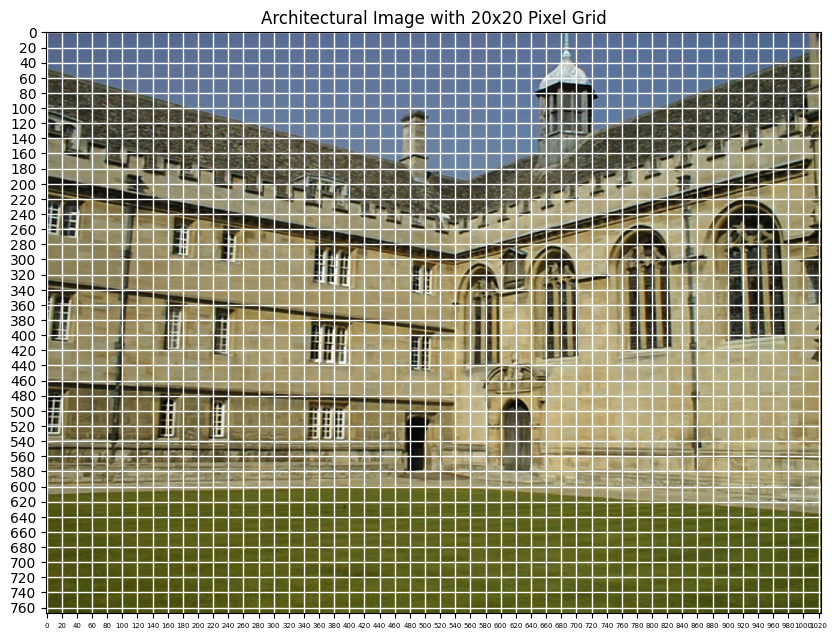

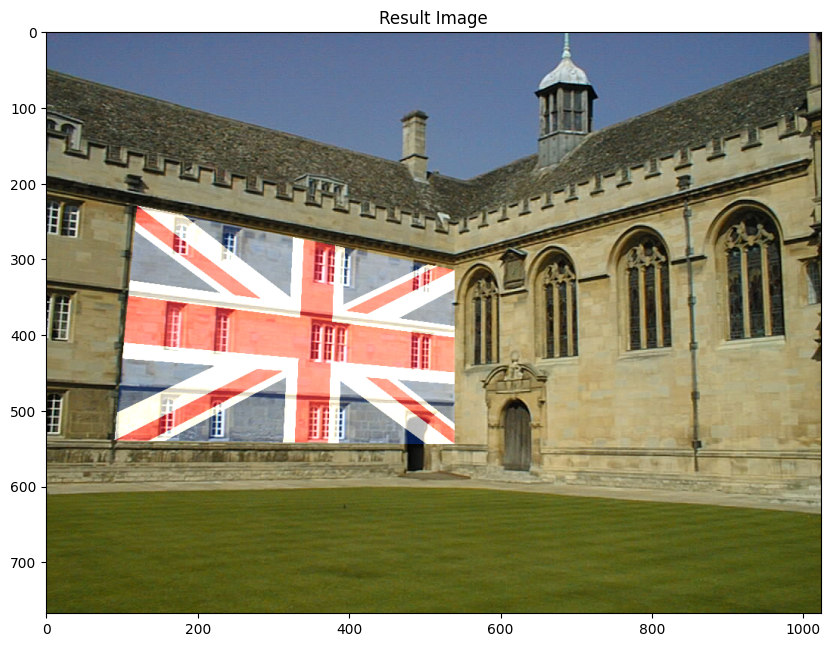

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the architectural image and the flag image
architectural_image = cv2.imread('architectural_image.jpg')
flag_image = cv2.imread('flag_image.png')

# Display the architectural image with a 20x20 pixel grid
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(architectural_image, cv2.COLOR_BGR2RGB))
plt.xticks(np.arange(0, architectural_image.shape[1], 20), fontsize=5)
plt.yticks(np.arange(0, architectural_image.shape[0], 20))
plt.grid(True, color='white', linewidth=1)
plt.title('Architectural Image with 20x20 Pixel Grid')
plt.show()

# Define the four points on the architectural image that form a planar surface
# Replace these with the actual coordinates
points_on_architecture = np.array([[120, 230], [540, 315], [540, 545], [90, 540]], dtype=np.float32)

# Define the corresponding points on the flag image (in the same order)
points_on_flag = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv2.findHomography(points_on_flag, points_on_architecture)

# Warp the flag image onto the architectural image using the homography
flag_warped = cv2.warpPerspective(flag_image, homography_matrix, (architectural_image.shape[1], architectural_image.shape[0]))

# Blend the warped flag image with the architectural image
result_image = cv2.addWeighted(architectural_image, 1, flag_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.show()



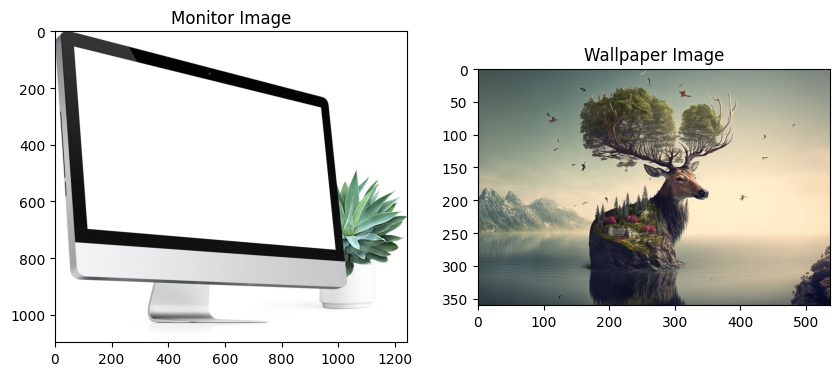

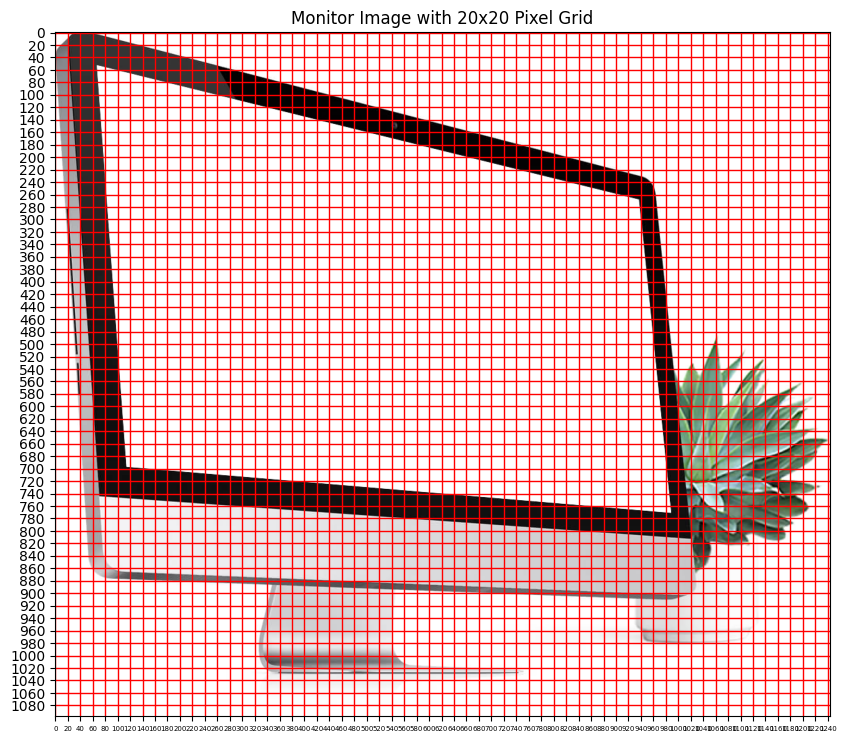

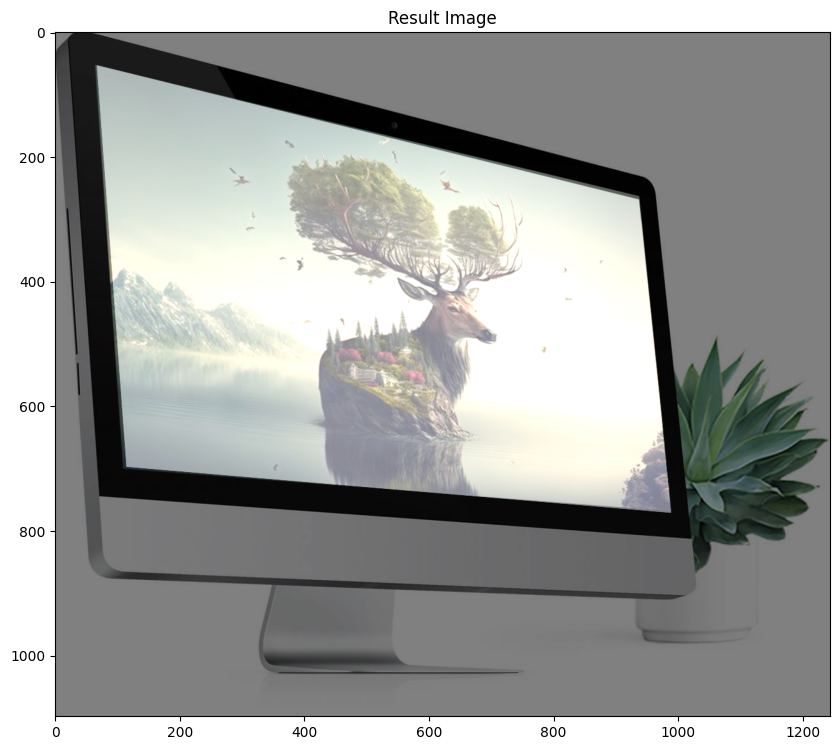

In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the monitor image and the wallpaper image
monitor_image = cv2.imread('monitor.png')
wallpaper_image = cv2.imread('new_image.jpg')

# Display two images side-by-side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(monitor_image, cv2.COLOR_BGR2RGB))
plt.title('Monitor Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(wallpaper_image, cv2.COLOR_BGR2RGB))
plt.title('Wallpaper Image')
plt.show()

# Display the monitor image with a 20x20 pixel grid
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(monitor_image, cv2.COLOR_BGR2RGB))
plt.xticks(np.arange(0, monitor_image.shape[1], 20), fontsize=5)
plt.yticks(np.arange(0, monitor_image.shape[0], 20))
plt.grid(True, color='red', linewidth=1)
plt.title('Monitor Image with 20x20 Pixel Grid')
plt.show()

# Define the four points on the monitor image that form a planar surface
# Replace these with the actual coordinates
points_on_monitor = np.array([[65, 55], [938, 265], [990, 770], [110, 702]], dtype=np.float32)

# Define the corresponding points on the wallpaper image (in the same order)
points_on_wallpaper = np.array([[0, 0], [wallpaper_image.shape[1], 0], [wallpaper_image.shape[1], wallpaper_image.shape[0]], [0, wallpaper_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv2.findHomography(points_on_wallpaper, points_on_monitor)

# Warp the wallpaper image onto the monitor image using the homography
wallpaper_warped = cv2.warpPerspective(wallpaper_image, homography_matrix, (monitor_image.shape[1], monitor_image.shape[0]))

# Blend the warped wallpaper image with the monitor image
result_image = cv2.addWeighted(monitor_image, 0.5, wallpaper_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.show()


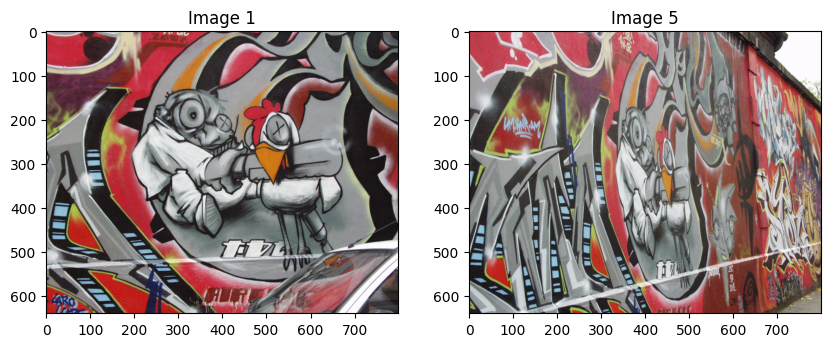

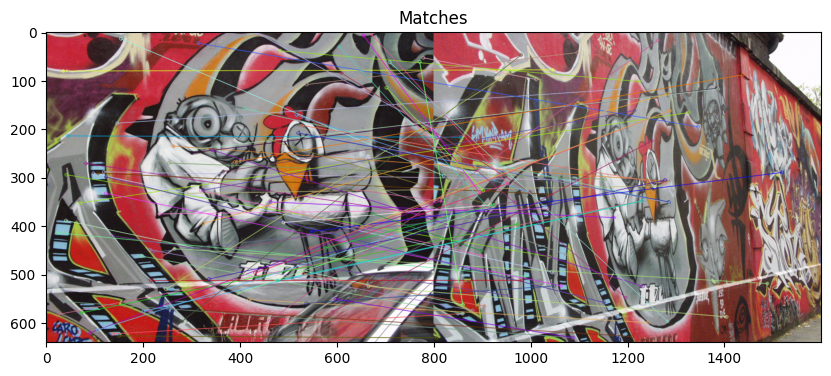

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('img1.ppm', cv2.IMREAD_ANYCOLOR)
img5 = cv2.imread('img5.ppm', cv2.IMREAD_ANYCOLOR)

# Plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Image 5')
plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
plt.show()

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors in both images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

# Create a brute-force matcher
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
        pts1.append(keypoints1[m.queryIdx].pt)
        pts2.append(keypoints5[m.trainIdx].pt)

# Draw the matches
match_img = cv2.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Save the image with matches
cv2.imwrite('matches.jpg', match_img)

# Change the image to RGB color space
#match_img = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)

# Plot the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

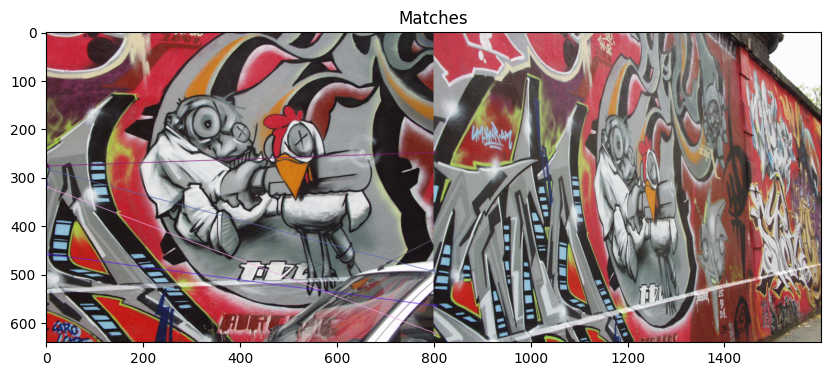

Homography Matrix:
[[-7.37929333e-01 -3.66327381e-01  4.30735910e+02]
 [-5.54081458e-01 -2.96580859e-01  3.32323195e+02]
 [-1.70096755e-03 -8.63964864e-04  1.00000000e+00]]
 
Original Homography Matrix:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


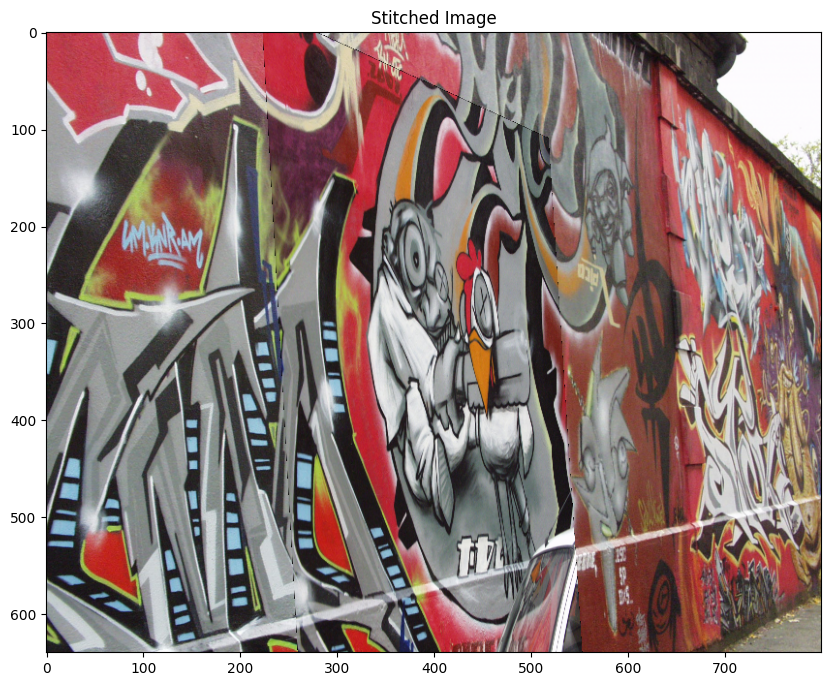

In [7]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def ransac_matching(img1, img2, num_iterations=1000, max_distance=10, min_inliers=100):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors in both images
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img5, None)

    # Create a brute-force matcher
    bf = cv2.BFMatcher()

    best_matches = []  # Store the best matches found by RANSAC
    best_homography = None  # Store the best homography matrix
    best_inliers = []  # Store the inliers of the best model

    for _ in range(num_iterations):
        # Randomly select four matches
        random_matches = random.sample(range(len(keypoints1)), 4)

        # Get the keypoints for the selected matches
        src_pts = np.float32([keypoints1[m].pt for m in random_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m].pt for m in random_matches]).reshape(-1, 1, 2)
        

        # Compute the homography matrix
        homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, max_distance)

        # Transform keypoints from img1 to img2 using the computed homography
        transformed_pts = cv2.perspectiveTransform(src_pts, homography)

        # Calculate the Euclidean distances between transformed and actual keypoints in img2
        distances = np.sqrt(np.sum((dst_pts - transformed_pts) ** 2, axis=2))

        # Count the number of inliers (matches within a certain distance threshold)
        inliers = np.count_nonzero(distances < max_distance)

        # Update if this model has more inliers than the current best
        if inliers > len(best_inliers):
            best_inliers = distances < max_distance
            best_matches = random_matches
            best_homography = homography

        # If we have enough inliers, exit early
        if inliers >= min_inliers:
            break

    # Filter the best matches using inliers
    filtered_matches = [cv2.DMatch(i, i, 0) for i, is_inlier in enumerate(best_inliers) if is_inlier]

    return filtered_matches, best_homography, keypoints1, keypoints2


# Find matching points using custom RANSAC
matches, homography, keypoints1, keypoints2 = ransac_matching(img1, img5)

# Draw the matching points
matched_img = cv2.drawMatches(img1, keypoints1, img5, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.show()

print("Homography Matrix:")
print(homography)

print(" ")

# Load homography matrix from file
homography = np.loadtxt(r"E:\UOM\Academic\Semester 5\Image processing and machine vision\EN3160---Image-Processing-and-Machine-Vision\Assignment_02  - Fitting and Alignment\graf\H1to5p")

# Print the original homography matrix
print("Original Homography Matrix:")
print(homography)

# Warp img1 onto img5 using the homography
img1_warped = cv2.warpPerspective(img1, homography, (img5.shape[1], img5.shape[0]))

# Create a binary mask of the warped image
_, img1_mask = cv2.threshold(cv2.cvtColor(img1_warped, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)

# Invert the mask to get the region where img1 should be placed
img5_mask = cv2.bitwise_not(img1_mask)

# Blend the two images together
result = cv2.bitwise_and(img5, img5, mask=img5_mask)
result = cv2.add(result, img1_warped)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.title('Stitched Image')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()
